In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import pickle

In [ ]:
train_images=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/train_images.pkl','rb'))
test_images=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/test_images.pkl','rb'))
TRAINING_LABELS=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/TRAINING_LABELS.pkl','rb'))
TESTING_LABELS=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/TESTING_LABELS.pkl','rb'))
train_masks=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/train_masks.pkl','rb'))
test_masks=pickle.load(
      open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/test_masks.pkl','rb'))
# train_borders=pickle.load(
#     open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/train_borders.pkl','rb'))
# test_borders=pickle.load(
#     open('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/test_borders.pkl','rb'))

In [ ]:
resized_train_images=np.array([ cv2.resize(i,
                                           (28,28)) for i in train_images]).reshape(2800,28,28,1)
resized_test_images=np.array([ cv2.resize(i,
                                          (28,28)) for i in test_images]).reshape(264,28,28,1)
resized_train_masks=np.array([ cv2.resize(i,
                                          (28,28)) for i in train_masks]).reshape(2800,28,28,1)
resized_test_masks=np.array([ cv2.resize(i,
                                         (28,28)) for i in test_masks]).reshape(264,28,28,1)

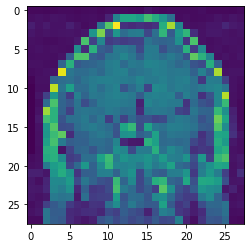

In [ ]:
plt.imshow(np.array(resized_train_images[0]).reshape(28,28))

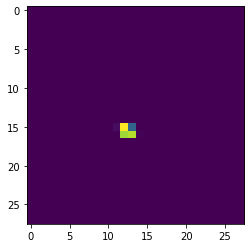

In [ ]:
plt.imshow(resized_train_masks[0].reshape(28,28)*resized_train_images[0].reshape(28,28))

In [ ]:
from sklearn.preprocessing import LabelEncoder
TRAINING_LABELS['encoded_label']=LabelEncoder().fit_transform(TRAINING_LABELS['x_train'])

In [ ]:
TESTING_LABELS['encoded_label']=LabelEncoder().fit_transform(TESTING_LABELS['x_test'])
TESTING_LABELS.head()

,x_test,glioma Tumor,meningioma Tumor,pituitary Tumor,encoded_label
0,pituitary Tumor,0.0,0.0,1.0,2
1,meningioma Tumor,0.0,1.0,0.0,1
2,meningioma Tumor,0.0,1.0,0.0,1
3,pituitary Tumor,0.0,0.0,1.0,2
4,glioma Tumor,1.0,0.0,0.0,0


In [ ]:
TRAINING_LABELS.head() 

,x_train,glioma Tumor,meningioma Tumor,pituitary Tumor,encoded_label
0,pituitary Tumor,0.0,0.0,1.0,2
1,pituitary Tumor,0.0,0.0,1.0,2
2,pituitary Tumor,0.0,0.0,1.0,2
3,meningioma Tumor,0.0,1.0,0.0,1
4,glioma Tumor,1.0,0.0,0.0,0


## Bayesian Squeeze and Excitation Learning with Approx KL Divergence

Posterior and Prior Distributions

In [ ]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return lambda t: tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(n, dtype=dtype),
                                                scale=1),
                                     reinterpreted_batch_ndims=1)

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return keras.models.Sequential([
        tfp.layers.VariableLayer(tfp.layers.IndependentNormal.params_size(n), dtype=dtype),
        tfp.layers.IndependentNormal(n)
    ])

Squeeze and Excitation Block

In [ ]:
def SE_BLOCK(in_block, ch, ratio=16):
    x = keras.layers.GlobalAveragePooling2D()(in_block)
    x = tfp.layers.DenseVariational(ch//ratio, posterior, prior,activation='relu',
                                    kl_weight=1/train_images.shape[0],
                              kl_use_exact=True)(x)
    x = tfp.layers.DenseVariational(ch, posterior, prior, 
                                    kl_weight=1/train_images.shape[0],activation='sigmoid',
                              kl_use_exact=True)(x)
    x = tf.reshape(x, shape=[-1, 1, 1, ch], name='scaler')
    return keras.layers.multiply([in_block, x])

KL- Divergence

In [ ]:
Exact_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, 
                                                          p) / train_images.shape[0]
def approximate_kl(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))
Approx_divergence_fn = lambda q, p, q_tensor : approximate_kl(q, p, 
                                                      q_tensor) / train_images.shape[0]

Architecture

In [ ]:
Input_=keras.layers.Input(shape=(128,128,1))

Hidden_1=keras.layers.Conv2D(64, (3,3), activation='relu',padding='same')(Input_)
padding_1=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(Hidden_1)
Attension_1=SE_BLOCK(padding_1,64)

Hidden_2=keras.layers.Conv2D(64, (3,3), activation='relu',padding='same')(Attension_1)
padding_2=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(Hidden_2)
Attension_2=SE_BLOCK(padding_2,64)

Hidden_3=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(padding_2)
padding_3=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(Hidden_3)
Attension_3=SE_BLOCK(padding_3,32)

con_1=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(Attension_3)
con_1_=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(con_1)
pad_1=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(con_1_)

con_2=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(pad_1)
con_2_=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(con_2)
pad_2=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(con_2_)

con_3=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(pad_2)
con_3_=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(con_3)
pad_3=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(con_3_)


Flat=keras.layers.Flatten()(pad_3)

Dense_1=keras.layers.Dense(512,activation='relu')(Flat)
drop_1=keras.layers.Dropout(0.3)(Dense_1)
BN_1=keras.layers.BatchNormalization()(drop_1)
Dense_2=keras.layers.Dense(256,activation='relu',)(BN_1)
drop_2=keras.layers.Dropout(0.2)(Dense_2)

Dense_=keras.layers.Dense(128,activation='relu')(drop_2)
drop_=keras.layers.Dropout(0.2)(Dense_)
BN_=keras.layers.BatchNormalization()(drop_)

BN_2=keras.layers.BatchNormalization()(BN_)
Dense_3=keras.layers.Dense(64,activation='relu',)(BN_2)
last_dense=keras.layers.Dense(3,activation='softmax')(Dense_3)

In [ ]:
BI_Based_SE_Architecture_3=keras.models.Model([Input_],[last_dense])

In [ ]:
BI_Based_SE_Architecture_3.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = keras.optimizers.Adam(learning_rate=0.001),metrics = ['accuracy'])

In [ ]:
hist=BI_Based_SE_Architecture_3.fit(
                   train_images,
                   TRAINING_LABELS['encoded_label'].values,
                   epochs=100,validation_split=0.20)

Epoch 1/100
70/70 [==============================] - 6s 43ms/step - loss: 1.0124 - accuracy: 0.5670 - val_loss: 1.2014 - val_accuracy: 0.5000
Epoch 2/100
70/70 [==============================] - 2s 31ms/step - loss: 0.7917 - accuracy: 0.6464 - val_loss: 0.8538 - val_accuracy: 0.6339
Epoch 3/100
70/70 [==============================] - 2s 32ms/step - loss: 0.6503 - accuracy: 0.7058 - val_loss: 0.7256 - val_accuracy: 0.6429
Epoch 4/100
70/70 [==============================] - 2s 32ms/step - loss: 0.5571 - accuracy: 0.7429 - val_loss: 0.6971 - val_accuracy: 0.7161
Epoch 5/100
70/70 [==============================] - 2s 32ms/step - loss: 0.5501 - accuracy: 0.7549 - val_loss: 0.5242 - val_accuracy: 0.7357
Epoch 6/100
70/70 [==============================] - 2s 32ms/step - loss: 0.5412 - accuracy: 0.7504 - val_loss: 0.6434 - val_accuracy: 0.6536
Epoch 7/100
70/70 [==============================] - 2s 32ms/step - loss: 0.4905 - accuracy: 0.7580 - val_loss: 0.6677 - val_accuracy: 0.7036
Epoch 

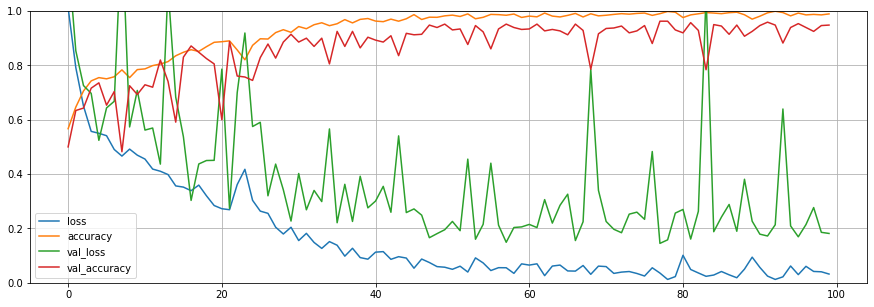

In [ ]:
pd.DataFrame(hist.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

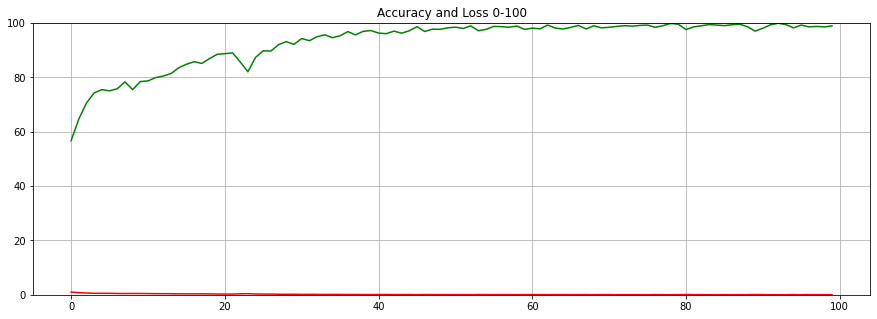

In [ ]:
plt.rcParams['figure.figsize']=(15,5)
plt.plot(hist.history['loss'],color='red')
plt.plot(np.array(hist.history['accuracy'])*100,color='green')
plt.title('Accuracy and Loss 0-100')
plt.grid()
plt.gca().set_ylim(0,100)
plt.show()

In [ ]:
BI_Based_SE_Architecture_3.evaluate(
          test_images,
          TESTING_LABELS['encoded_label'].values
                  )

9/9 [==============================] - 0s 15ms/step - loss: 0.3689 - accuracy: 0.9318


[0.3688904643058777, 0.9318181872367859]

## 2. Model with Inference in Last Layers

In [ ]:
Input_=keras.layers.Input(shape=(128,128,1))

Hidden_1=keras.layers.Conv2D(64, (3,3), activation='relu',padding='same')(Input_)
padding_1=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(Hidden_1)
Attension_1=SE_BLOCK(padding_1,64)

Hidden_2=keras.layers.Conv2D(64, (3,3), activation='relu',padding='same')(Attension_1)
padding_2=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(Hidden_2)
Attension_2=SE_BLOCK(padding_2,64)

Hidden_3=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(padding_2)
padding_3=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(Hidden_3)
Attension_3=SE_BLOCK(padding_3,32)

con_1=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(Attension_3)
con_1_=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(con_1)
pad_1=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(con_1_)

con_2=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(pad_1)
con_2_=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(con_2)
pad_2=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(con_2_)

con_3=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(pad_2)
con_3_=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(con_3)
pad_3=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(con_3_)


Flat=keras.layers.Flatten()(pad_3)

Dense_network=tfp.layers.DenseReparameterization(
            units=tfp.layers.OneHotCategorical.params_size(3), activation=None,
            kernel_prior_fn = tfp.layers.default_multivariate_normal_fn,
            kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
            kernel_divergence_fn = Approx_divergence_fn,
            bias_prior_fn = tfp.layers.default_multivariate_normal_fn,
            bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
            bias_divergence_fn = Approx_divergence_fn)(Flat)
output_1=tfp.layers.OneHotCategorical(3)(Dense_network)

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


In [ ]:
BI_Based_SE_Architecture_4=keras.models.Model([Input_],[output_1])

In [ ]:
def negative_log_likelihood(y_true, y_pred):
    return -tf.reduce_sum(y_pred.log_prob(y_true))

BI_Based_SE_Architecture_4.compile(loss = negative_log_likelihood,
             optimizer = keras.optimizers.Adam(learning_rate=0.005),metrics = ['accuracy'])

In [ ]:
hist_2=BI_Based_SE_Architecture_4.fit(
                   train_images,
      TRAINING_LABELS[['glioma Tumor','meningioma Tumor','pituitary Tumor']].values,
                   epochs=100,validation_split=0.15)

Epoch 1/100
75/75 [==============================] - 6s 39ms/step - loss: 32.2022 - accuracy: 0.4416 - val_loss: 27.6077 - val_accuracy: 0.4571
Epoch 2/100
75/75 [==============================] - 2s 30ms/step - loss: 25.9067 - accuracy: 0.5374 - val_loss: 30.9163 - val_accuracy: 0.6286
Epoch 3/100
75/75 [==============================] - 2s 30ms/step - loss: 23.8553 - accuracy: 0.5756 - val_loss: 20.8641 - val_accuracy: 0.6024
Epoch 4/100
75/75 [==============================] - 2s 30ms/step - loss: 19.8134 - accuracy: 0.6286 - val_loss: 16.4539 - val_accuracy: 0.6833
Epoch 5/100
75/75 [==============================] - 2s 30ms/step - loss: 19.9699 - accuracy: 0.6353 - val_loss: 20.5600 - val_accuracy: 0.5452
Epoch 6/100
75/75 [==============================] - 2s 30ms/step - loss: 17.6388 - accuracy: 0.6492 - val_loss: 21.4097 - val_accuracy: 0.6857
Epoch 7/100
75/75 [==============================] - 2s 30ms/step - loss: 16.8385 - accuracy: 0.6878 - val_loss: 17.0796 - val_accuracy:

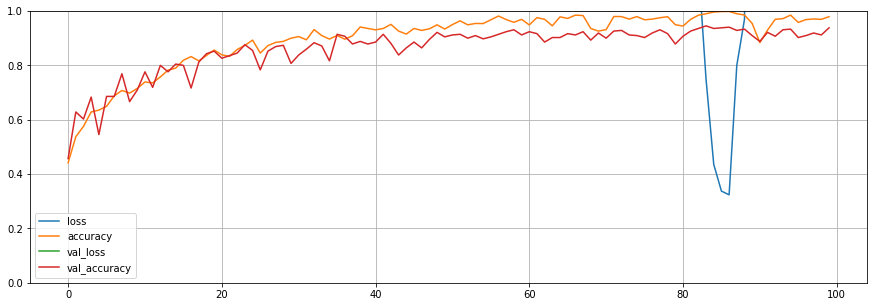

In [ ]:
pd.DataFrame(hist_2.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

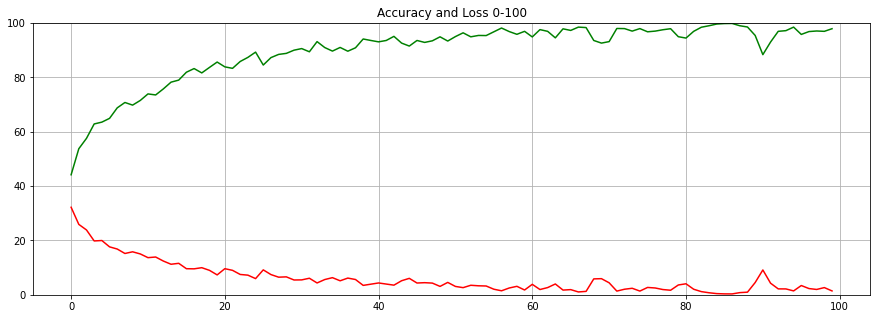

In [ ]:
plt.rcParams['figure.figsize']=(15,5)
plt.plot(hist_2.history['loss'],color='red')
plt.plot(np.array(hist_2.history['accuracy'])*100,color='green')
plt.title('Accuracy and Loss 0-100')
plt.grid()
plt.gca().set_ylim(0,100)
plt.show()

In [ ]:
BI_Based_SE_Architecture_4.evaluate(
          test_images,
         TESTING_LABELS[['glioma Tumor','meningioma Tumor','pituitary Tumor']].values
                  )

9/9 [==============================] - 0s 15ms/step - loss: 4.2875 - accuracy: 0.9432


[4.287459850311279, 0.9431818127632141]

## Multi Output *Architecture*

In [ ]:
Input_=keras.layers.Input(shape=(128,128,1))

Hidden_1=keras.layers.Conv2D(64, (3,3), activation='relu',padding='same')(Input_)
padding_1=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(Hidden_1)
Attension_1=SE_BLOCK(padding_1,64)

Hidden_2=keras.layers.Conv2D(64, (3,3), activation='relu',padding='same')(Attension_1)
padding_2=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(Hidden_2)
Attension_2=SE_BLOCK(padding_2,64)

Hidden_3=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(padding_2)
padding_3=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(Hidden_3)
Attension_3=SE_BLOCK(padding_3,32)

con_1=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(Attension_3)
con_1_=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(con_1)
pad_1=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(con_1_)

con_2=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(pad_1)
con_2_=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(con_2)
pad_2=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(con_2_)

con_3=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(pad_2)
con_3_=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(con_3)
pad_3=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(con_3_)


Flat=keras.layers.Flatten()(pad_3)

Dense_1=keras.layers.Dense(512,activation='relu')(Flat)
drop_1=keras.layers.Dropout(0.3)(Dense_1)
BN_1=keras.layers.BatchNormalization()(drop_1)
Dense_2=keras.layers.Dense(256,activation='relu')(BN_1)
drop_2=keras.layers.Dropout(0.2)(Dense_2)
BN_2=keras.layers.BatchNormalization()(drop_2)
Dense_3=keras.layers.Dense(64,activation='relu')(BN_2)
Dense_4=keras.layers.Dense(32,activation='relu')(Dense_3)
output_1=keras.layers.Dense(1,activation='sigmoid')(Dense_3)
output_2=keras.layers.Dense(1,activation='sigmoid')(Dense_3)
output_3=keras.layers.Dense(1,activation='sigmoid')(Dense_3)

In [ ]:
BI_Based_SE_Architecture_5=keras.models.Model([Input_],[output_1,output_2,output_3])

In [ ]:
BI_Based_SE_Architecture_5.compile(loss ='binary_crossentropy',
             optimizer = keras.optimizers.Adam(learning_rate=0.005),
             metrics = ['accuracy'])

In [ ]:
hist_2=BI_Based_SE_Architecture_5.fit(
                   train_images,
      [TRAINING_LABELS['glioma Tumor'].values,
       TRAINING_LABELS['meningioma Tumor'].values,
      TRAINING_LABELS['pituitary Tumor'].values],
                   epochs=150,batch_size=100)

Epoch 1/150
28/28 [==============================] - 18s 76ms/step - loss: 1.6649 - dense_4_loss: 0.5683 - dense_5_loss: 0.5430 - dense_6_loss: 0.5293 - dense_4_accuracy: 0.7111 - dense_5_accuracy: 0.7254 - dense_6_accuracy: 0.7607
Epoch 2/150
28/28 [==============================] - 2s 76ms/step - loss: 1.3862 - dense_4_loss: 0.4871 - dense_5_loss: 0.4741 - dense_6_loss: 0.4073 - dense_4_accuracy: 0.7500 - dense_5_accuracy: 0.7689 - dense_6_accuracy: 0.8121
Epoch 3/150
28/28 [==============================] - 2s 76ms/step - loss: 1.2549 - dense_4_loss: 0.4715 - dense_5_loss: 0.4663 - dense_6_loss: 0.3034 - dense_4_accuracy: 0.7432 - dense_5_accuracy: 0.7650 - dense_6_accuracy: 0.8693
Epoch 4/150
28/28 [==============================] - 2s 76ms/step - loss: 1.0624 - dense_4_loss: 0.4162 - dense_5_loss: 0.4216 - dense_6_loss: 0.2131 - dense_4_accuracy: 0.7736 - dense_5_accuracy: 0.7800 - dense_6_accuracy: 0.9164
Epoch 5/150
28/28 [==============================] - 2s 76ms/step - loss: 1

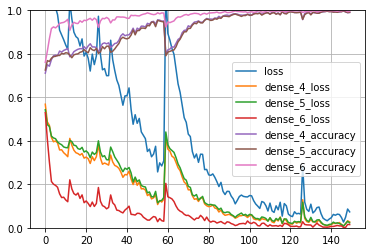

In [ ]:
pd.DataFrame(hist_2.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
BI_Based_SE_Architecture_5.evaluate(
          test_images, 
         [TESTING_LABELS['glioma Tumor'].values,
       TESTING_LABELS['meningioma Tumor'].values,
      TESTING_LABELS['pituitary Tumor'].values]
                  )

9/9 [==============================] - 0s 16ms/step - loss: 0.4605 - dense_4_loss: 0.2129 - dense_5_loss: 0.2056 - dense_6_loss: 0.0333 - dense_4_accuracy: 0.9470 - dense_5_accuracy: 0.9470 - dense_6_accuracy: 0.9886


[0.4604806900024414,
 0.21289518475532532,
 0.20560209453105927,
 0.03334277123212814,
 0.9469696879386902,
 0.9469696879386902,
 0.9886363744735718]

In [ ]:
(0.9469696879386902+0.9469696879386902+0.9886363744735718)/3

0.9608585834503174

## Entangled Network

In [ ]:
Input_=keras.layers.Input(shape=(128,128,1))

Hidden_1=keras.layers.Conv2D(16, (3,3), activation='relu',padding='same')(Input_)
# padding_1=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(Hidden_1)
Attension_1=SE_BLOCK(Hidden_1,16)

Hidden_2=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(Attension_1)
# padding_2=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(Hidden_2)
Attension_2=SE_BLOCK(Hidden_2,32)

Hidden_3=keras.layers.Conv2D(16, (3,3), activation='relu',padding='same')(Attension_2)
# padding_3=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(Hidden_3)
Attension_3=SE_BLOCK(Hidden_3,16)

# con_1=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(Attension_3)
# con_1_=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(con_1)
# # pad_1=tf.keras.layers.MaxPooling2D(pool_size=[2, 2])(con_1_)

# con_2=keras.layers.Conv2D(16, (3,3), activation='relu',padding='same')(con_1_)
# con_2_=keras.layers.Conv2D(16, (3,3), activation='relu',padding='same')(con_2)
# # pad_2=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(con_2_)

# con_3=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(con_2_)
# con_3_=keras.layers.Conv2D(32, (3,3), activation='relu',padding='same')(con_3)
# pad_3=tf.keras.layers.MaxPooling2D(pool_size=[2, 2],padding='same')(con_3_)

gb_pooling=keras.layers.GlobalAveragePooling2D()(Attension_3)
Flat=keras.layers.Flatten()(gb_pooling)
#(keras.layers.concatenate([
                                       #               Attension_1,Attension_2,Attension_3]))

Dense_1=keras.layers.Dense(256,activation='relu')(Flat)
drop_1=keras.layers.Dropout(0.3)(keras.layers.concatenate([Dense_1,Flat]))
BN_1=keras.layers.BatchNormalization()(drop_1)
Dense_2=keras.layers.Dense(128,activation='relu')(keras.layers.concatenate([BN_1,Flat]))
drop_2=keras.layers.Dropout(0.1)(Dense_2)
BN_2=keras.layers.BatchNormalization()(drop_2)
Dense_3=keras.layers.Dense(64,activation='relu')(keras.layers.concatenate([BN_2,Flat]))
Dense_4=keras.layers.Dense(32,activation='relu')(keras.layers.concatenate([Dense_3,Flat]))
output_1=keras.layers.Dense(1,activation='sigmoid')(Dense_3)
output_2=keras.layers.Dense(1,activation='sigmoid')(Dense_3)
output_3=keras.layers.Dense(1,activation='sigmoid')(Dense_3)

In [ ]:
BI_Based_SE_Architecture_6=keras.models.Model([Input_],[output_1,output_2,output_3])

In [ ]:
BI_Based_SE_Architecture_6.compile(loss ='binary_crossentropy',
             optimizer = keras.optimizers.Adam(learning_rate=0.001),
             metrics = ['accuracy'])

In [ ]:
hist_2=BI_Based_SE_Architecture_6.fit(
                   train_images,
      [TRAINING_LABELS['glioma Tumor'].values,
       TRAINING_LABELS['meningioma Tumor'].values,
      TRAINING_LABELS['pituitary Tumor'].values],
                   epochs=10)

In [ ]:
pd.DataFrame(hist_2.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

## AdiaBolo Network for Segmentation - 2D Embedding

In [ ]:
Encoder=keras.models.Sequential([
      keras.layers.Input(shape=(28,28,1)),
      keras.layers.Conv2D(16,(3,3),padding='same' ),
      keras.layers.MaxPooling2D((2,2)),
      keras.layers.Conv2D(8,(3,3),padding='same' ),
      keras.layers.MaxPooling2D((2,2)),
      # keras.layers.Conv2D(4,(3,3),padding='same'),
      keras.layers.Flatten(),
      keras.layers.Dense(512,activation='relu'),
      keras.layers.Dense(256,activation='relu'),
      keras.layers.Dense(128,activation='relu'),
      keras.layers.Dense(64,activation='relu'),
      keras.layers.Dense(2)
])
Decoder=keras.models.Sequential([
  keras.layers.Input(shape=[2]),
  keras.layers.Dense(128,activation='selu'),
  keras.layers.Reshape((4,4,8)),
  keras.layers.Conv2DTranspose(32,(3,3)),
  keras.layers.Conv2DTranspose(16,(3,3)),
  keras.layers.UpSampling2D(),
  # keras.layers.Conv2DTranspose(16,(3,3)),
  # keras.layers.Conv2DTranspose(8,(3,3)),
  # keras.layers.UpSampling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(784,activation='sigmoid'),
  keras.layers.Reshape((28,28,1))
])

In [ ]:
Decoder(Encoder(resized_train_images)).shape

TensorShape([2800, 28, 28, 1])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


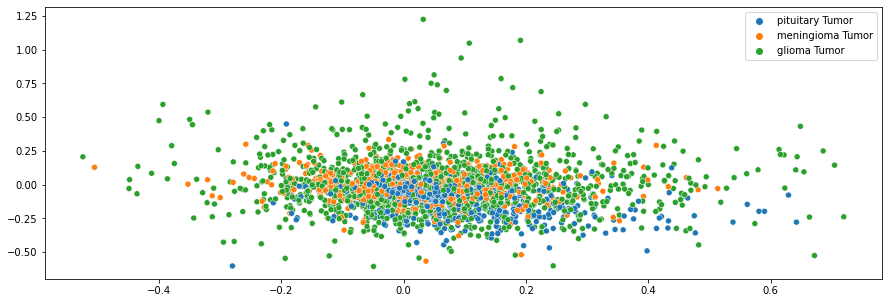

In [ ]:
import seaborn as sns
plt.rcParams['figure.figsize']=(15,5)
encoded=Encoder(resized_train_images).numpy()
class_names=np.array(['glioma Tumor','meningioma Tumor','pituitary Tumor'])
sns.scatterplot(encoded[:,0],encoded[:,1],hue=class_names[TRAINING_LABELS['encoded_label']])
plt.show()

In [ ]:
AutoEncoder=keras.models.Model([Encoder.input],[Decoder(Encoder.output)])

In [ ]:
AutoEncoder.compile(optimizer=keras.optimizers.Adam (learning_rate=0.001),
                    loss='binary_crossentropy',metrics=['accuracy'])
hist=AutoEncoder.fit(resized_train_images,resized_train_masks,epochs=10)

Epoch 1/10
88/88 [==============================] - 4s 9ms/step - loss: 0.0950 - accuracy: 0.9713
Epoch 2/10
88/88 [==============================] - 1s 8ms/step - loss: 0.0620 - accuracy: 0.9803
Epoch 3/10
88/88 [==============================] - 1s 8ms/step - loss: 0.0603 - accuracy: 0.9803
Epoch 4/10
88/88 [==============================] - 1s 8ms/step - loss: 0.0589 - accuracy: 0.9803
Epoch 5/10
88/88 [==============================] - 1s 8ms/step - loss: 0.0577 - accuracy: 0.9803
Epoch 6/10
88/88 [==============================] - 1s 8ms/step - loss: 0.0567 - accuracy: 0.9803
Epoch 7/10
88/88 [==============================] - 1s 8ms/step - loss: 0.0557 - accuracy: 0.9804
Epoch 8/10
88/88 [==============================] - 1s 8ms/step - loss: 0.0535 - accuracy: 0.9805
Epoch 9/10
88/88 [==============================] - 1s 8ms/step - loss: 0.0517 - accuracy: 0.9806
Epoch 10/10
88/88 [==============================] - 1s 8ms/step - loss: 0.0499 - accuracy: 0.9808


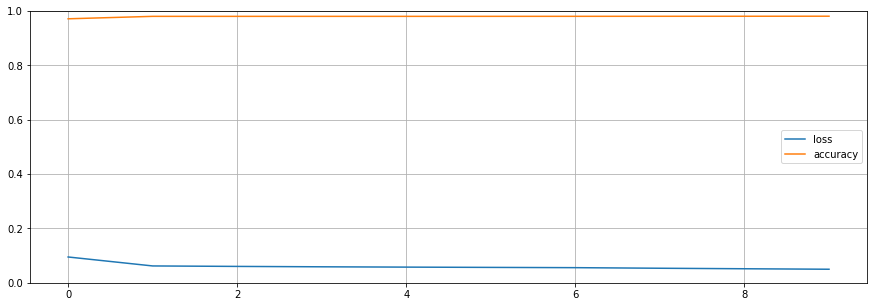

In [ ]:
pd.DataFrame(hist.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
preds=AutoEncoder.predict(resized_test_images)

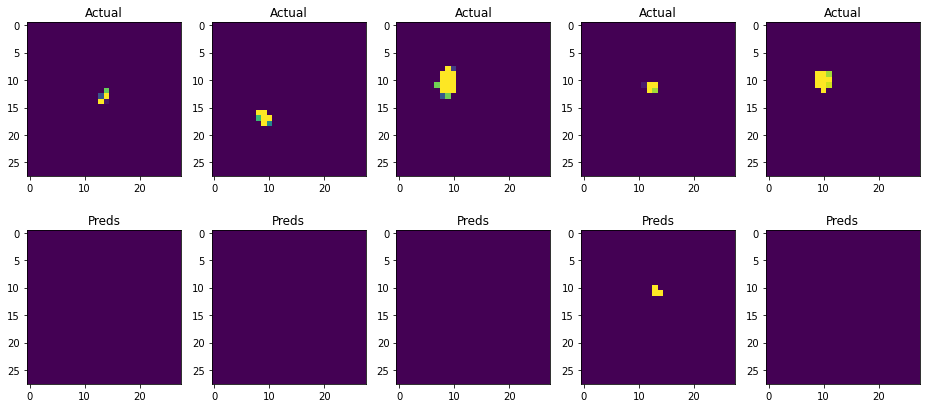

In [ ]:
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((resized_test_masks[i]).reshape(28,28))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow(np.array(np.round(preds[i])).reshape(28,28))
  plt.title('Preds')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


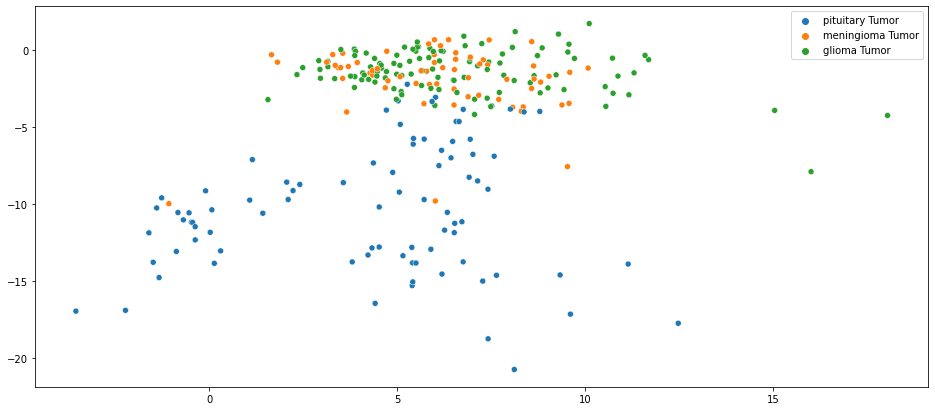

In [ ]:
import seaborn as sns
encoded=Encoder(resized_test_images).numpy()
class_names=np.array(['glioma Tumor','meningioma Tumor','pituitary Tumor'])
sns.scatterplot(encoded[:,0],encoded[:,1],hue=class_names[TESTING_LABELS['encoded_label']])
plt.show()

## 3D Embedding

In [ ]:
Encoder=keras.models.Sequential([
      keras.layers.Input(shape=(28,28,1)),
      keras.layers.Conv2D(16,(3,3),padding='same' ),
      keras.layers.MaxPooling2D((2,2)),
      keras.layers.Conv2D(8,(3,3),padding='same' ),
      keras.layers.MaxPooling2D((2,2)),
      # keras.layers.Conv2D(4,(3,3),padding='same'),
      keras.layers.Flatten(),
      keras.layers.Dense(512,activation='relu'),
      keras.layers.Dense(256,activation='relu'),
      keras.layers.Dense(128,activation='relu'),
      keras.layers.Dense(64,activation='relu'),
      keras.layers.Dense(3)
])
Decoder=keras.models.Sequential([
  keras.layers.Input(shape=[3]),
  keras.layers.Dense(128,activation='selu'),
  keras.layers.Reshape((4,4,8)),
  keras.layers.Conv2DTranspose(32,(3,3)),
  keras.layers.Conv2DTranspose(16,(3,3)),
  keras.layers.UpSampling2D(),
  # keras.layers.Conv2DTranspose(16,(3,3)),
  # keras.layers.Conv2DTranspose(8,(3,3)),
  # keras.layers.UpSampling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(784,activation='sigmoid'),
  keras.layers.Reshape((28,28,1))
])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


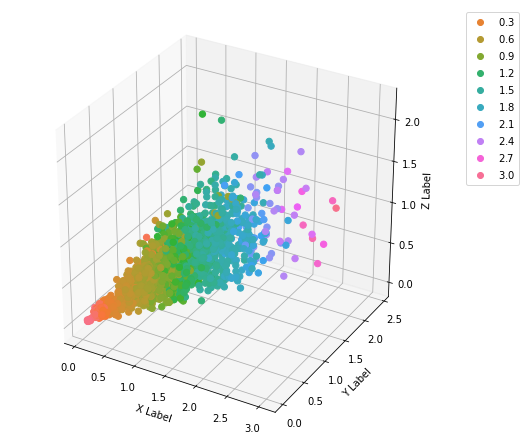

In [ ]:
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
plt.rcParams['figure.figsize']=(15,5)
encoded=Encoder(resized_train_images).numpy()

x = encoded[:,0]
y = encoded[:,1]
z = encoded[:,2]

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=x, marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)


In [ ]:
AutoEncoder=keras.models.Model([Encoder.input],[Decoder(Encoder.output)])

In [ ]:
AutoEncoder.compile(optimizer=keras.optimizers.Adam (learning_rate=0.001),
                    loss='binary_crossentropy',metrics=['accuracy'])
hist=AutoEncoder.fit(resized_train_images,resized_train_masks,epochs=200)

Epoch 1/200
88/88 [==============================] - 2s 8ms/step - loss: 0.0138 - accuracy: 0.9917
Epoch 2/200
88/88 [==============================] - 1s 6ms/step - loss: 0.0140 - accuracy: 0.9916
Epoch 3/200
88/88 [==============================] - 1s 6ms/step - loss: 0.0139 - accuracy: 0.9917
Epoch 4/200
88/88 [==============================] - 1s 6ms/step - loss: 0.0137 - accuracy: 0.9918
Epoch 5/200
88/88 [==============================] - 1s 6ms/step - loss: 0.0134 - accuracy: 0.9919
Epoch 6/200
88/88 [==============================] - 1s 6ms/step - loss: 0.0135 - accuracy: 0.9919
Epoch 7/200
88/88 [==============================] - 1s 6ms/step - loss: 0.0134 - accuracy: 0.9919
Epoch 8/200
88/88 [==============================] - 1s 6ms/step - loss: 0.0133 - accuracy: 0.9919
Epoch 9/200
88/88 [==============================] - 1s 6ms/step - loss: 0.0134 - accuracy: 0.9919
Epoch 10/200
88/88 [==============================] - 1s 6ms/step - loss: 0.0134 - accuracy: 0.9919
Epoch 11/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


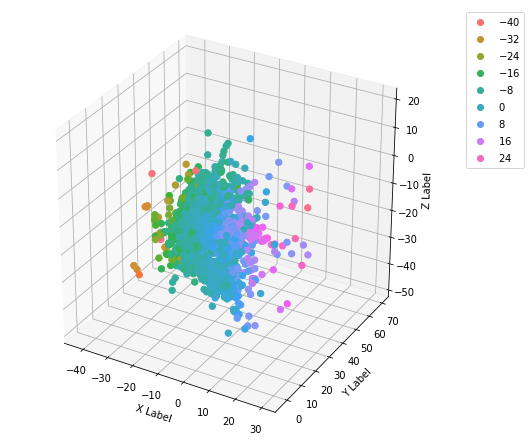

In [ ]:
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
plt.rcParams['figure.figsize']=(15,5)
encoded=Encoder(resized_train_images).numpy()

x = encoded[:,0]
y = encoded[:,1]
z = encoded[:,2]

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=x, marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)


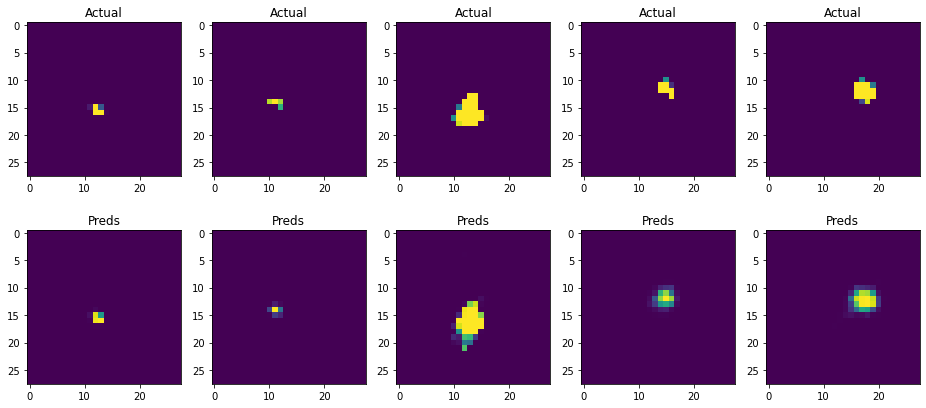

In [ ]:
preds=AutoEncoder.predict(resized_train_images)
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((resized_train_masks[i]).reshape(28,28))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow(np.array(preds[i]).reshape(28,28))
  plt.title('Preds')
plt.show()

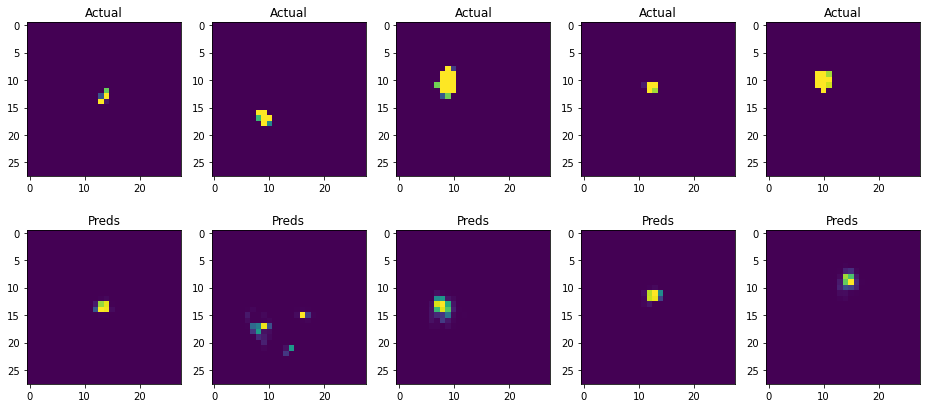

In [ ]:
preds=AutoEncoder.predict(resized_test_images)
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((resized_test_masks[i]).reshape(28,28))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow(np.array(preds[i]).reshape(28,28))
  plt.title('Preds')
plt.show()

In [ ]:
AutoEncoder.evaluate(resized_test_images,resized_test_masks)

9/9 [==============================] - 0s 4ms/step - loss: 0.0738 - accuracy: 0.9849


[0.07376852631568909, 0.9848967790603638]

## Higher Dimentional *Embedding* with 128 x 128 Image

In [ ]:
Encoder=keras.models.Sequential([
      keras.layers.Input(shape=(128,128,1)),
      keras.layers.Conv2D(16,(3,3),padding='same' ),
      keras.layers.MaxPooling2D((2,2)),
      keras.layers.Conv2D(8,(3,3),padding='same' ),
      keras.layers.MaxPooling2D((2,2)),
      # keras.layers.Conv2D(4,(3,3),padding='same'),
      keras.layers.Flatten(),
      keras.layers.Dense(512,activation='relu'),
      keras.layers.Dense(256,activation='relu'),
      keras.layers.Dense(128,activation='relu'),
      keras.layers.Dense(64,activation='relu'),
      keras.layers.Dense(8)
])
Decoder=keras.models.Sequential([
  keras.layers.Input(shape=[8]),
  keras.layers.Dense(128,activation='selu'),
  keras.layers.Reshape((4,4,8)),
  keras.layers.Conv2DTranspose(32,(3,3)),
  keras.layers.Conv2DTranspose(16,(3,3)),
  keras.layers.UpSampling2D(),
  keras.layers.Conv2DTranspose(16,(3,3)),
  keras.layers.Conv2DTranspose(8,(3,3)),
  keras.layers.UpSampling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(16384,activation='sigmoid'),
  keras.layers.Reshape((128,128,1))
])

In [ ]:
AutoEncoder=keras.models.Model([Encoder.input],[Decoder(Encoder.output)])

In [ ]:
AutoEncoder.compile(optimizer=keras.optimizers.Adam (learning_rate=0.001),
                    loss='binary_crossentropy',metrics=['accuracy'])
hist=AutoEncoder.fit(train_images,train_masks,epochs=100)

Epoch 1/100
88/88 [==============================] - 7s 61ms/step - loss: 0.0927 - accuracy: 0.9675
Epoch 2/100
88/88 [==============================] - 5s 60ms/step - loss: 0.0579 - accuracy: 0.9828
Epoch 3/100
88/88 [==============================] - 5s 60ms/step - loss: 0.0525 - accuracy: 0.9829
Epoch 4/100
88/88 [==============================] - 5s 61ms/step - loss: 0.0465 - accuracy: 0.9835
Epoch 5/100
88/88 [==============================] - 5s 60ms/step - loss: 0.0401 - accuracy: 0.9850
Epoch 6/100
88/88 [==============================] - 5s 60ms/step - loss: 0.0358 - accuracy: 0.9861
Epoch 7/100
88/88 [==============================] - 5s 60ms/step - loss: 0.0301 - accuracy: 0.9881
Epoch 8/100
88/88 [==============================] - 5s 60ms/step - loss: 0.0267 - accuracy: 0.9893
Epoch 9/100
88/88 [==============================] - 5s 59ms/step - loss: 0.0241 - accuracy: 0.9902
Epoch 10/100
88/88 [==============================] - 5s 59ms/step - loss: 0.0217 - accuracy: 0.9911

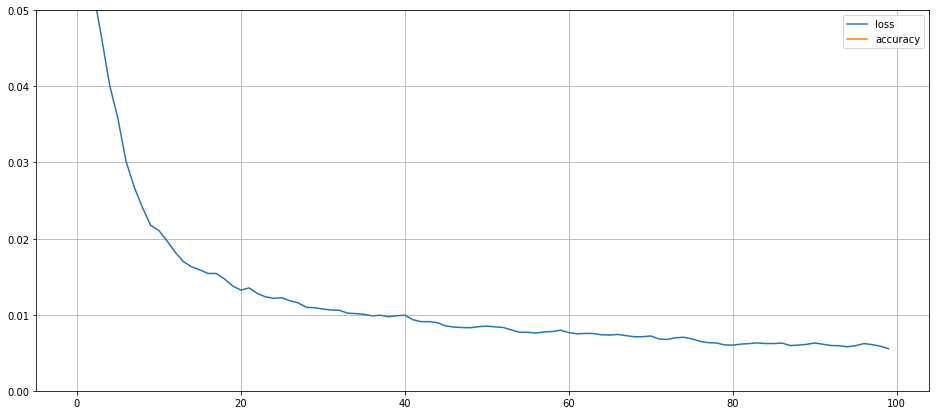

In [ ]:
pd.DataFrame(hist.history).plot()
plt.grid()
plt.gca().set_ylim(0,0.05)
plt.show()

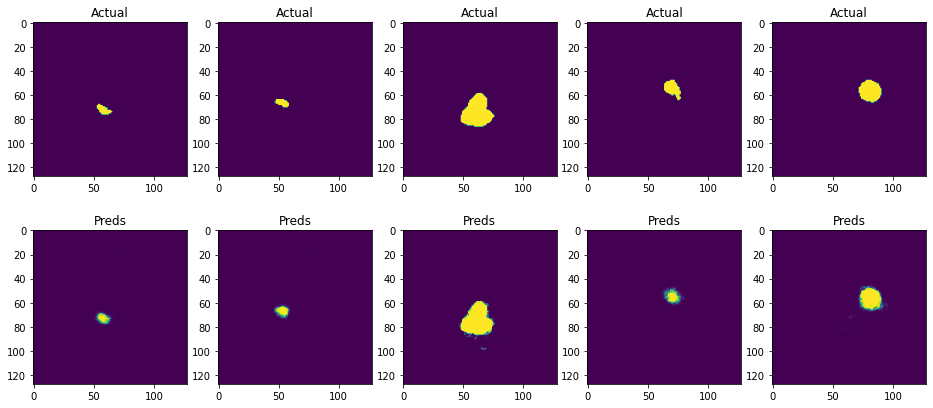

In [ ]:
preds=AutoEncoder.predict(train_images)
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((train_masks[i]).reshape(128,128))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow(np.array(preds[i]).reshape(128,128))
  plt.title('Preds')
plt.show()

In [ ]:
AutoEncoder.evaluate(test_images,test_masks)

9/9 [==============================] - 0s 12ms/step - loss: 0.0628 - accuracy: 0.9887


[0.06283724308013916, 0.9887052774429321]

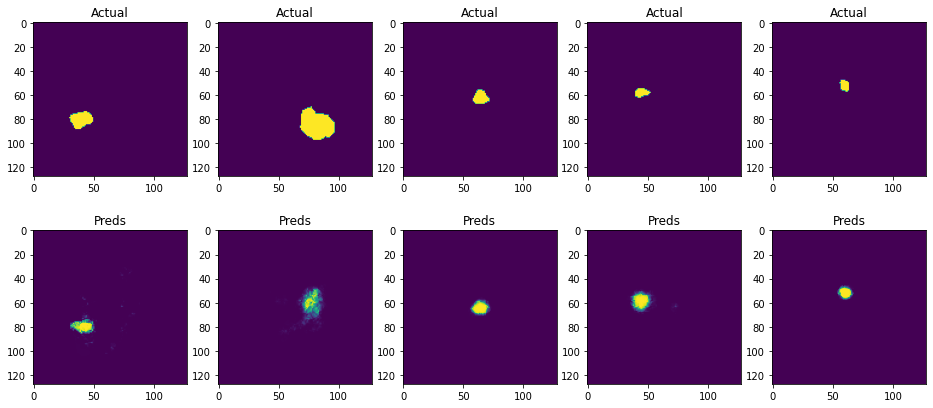

In [ ]:
preds=AutoEncoder.predict(test_images)
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((test_masks[i+13]).reshape(128,128))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow(np.array(preds[i+13]).reshape(128,128))
  plt.title('Preds')
plt.show()

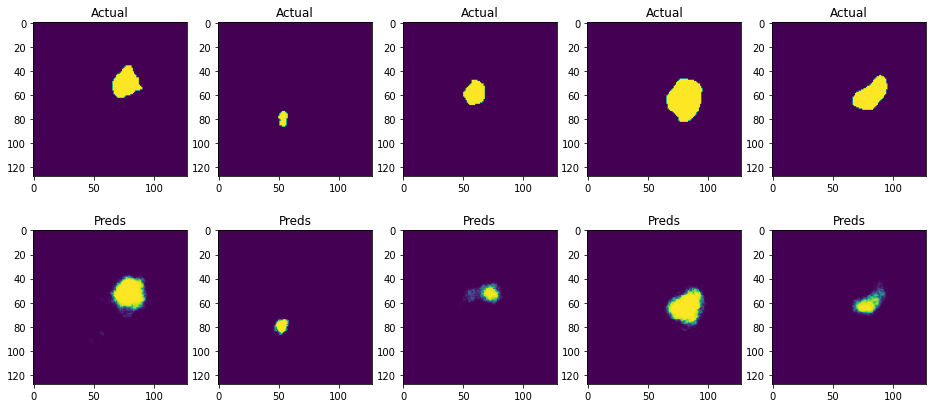

In [ ]:
preds=AutoEncoder.predict(test_images)
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((test_masks[i+30]).reshape(128,128))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow(np.array(preds[i+30]).reshape(128,128))
  plt.title('Preds')
plt.show()

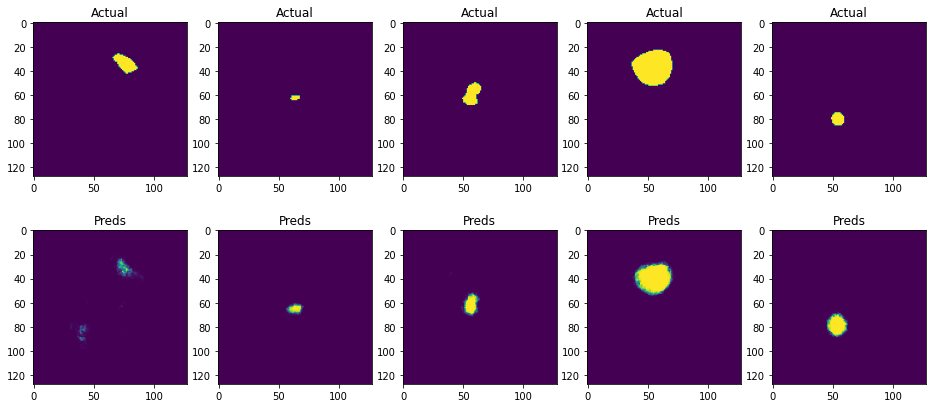

In [ ]:
preds=AutoEncoder.predict(test_images)
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((test_masks[i+42]).reshape(128,128))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow(np.array(preds[i+42]).reshape(128,128))
  plt.title('Preds')
plt.show()

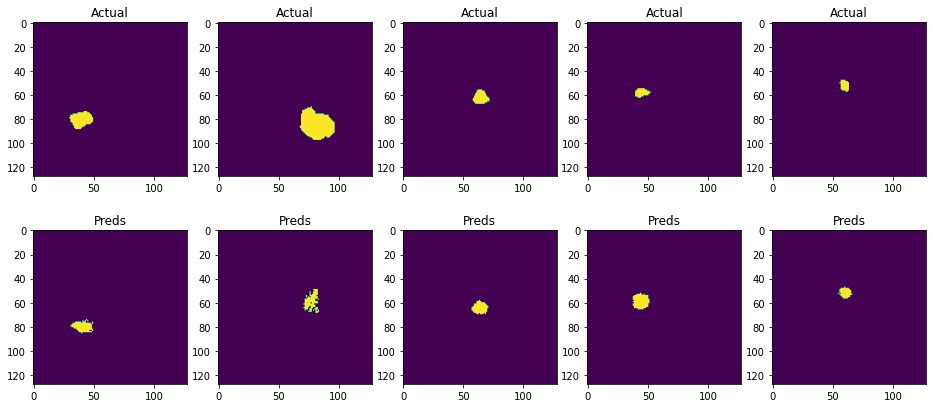

In [ ]:
preds=AutoEncoder.predict(test_images)
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((test_masks[i+13]).reshape(128,128))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow(np.array(np.round(preds[i+13])).reshape(128,128))
  plt.title('Preds')
plt.show()

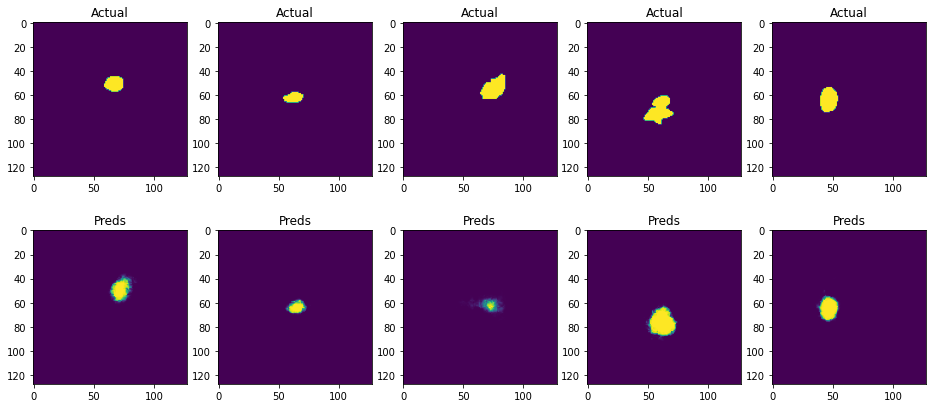

In [ ]:
preds=AutoEncoder.predict(test_images)
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((test_masks[i+123]).reshape(128,128))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow(np.array(preds[i+123]).reshape(128,128))
  plt.title('Preds')
plt.show()

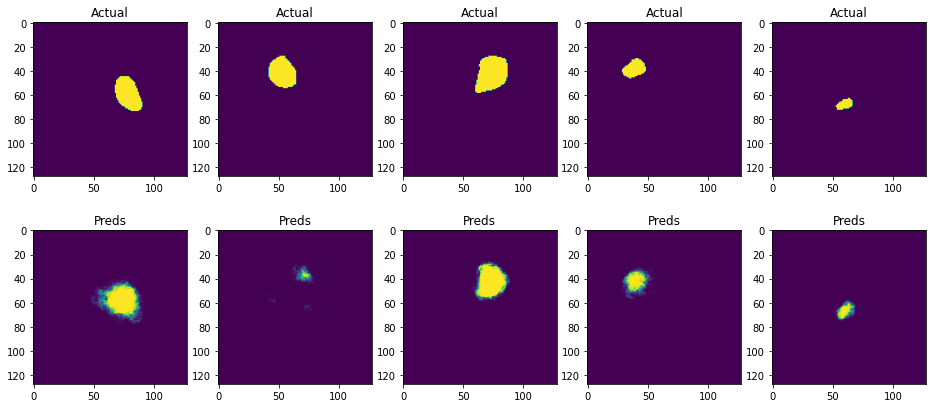

In [ ]:
preds=AutoEncoder.predict(test_images)
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((test_masks[i+236]).reshape(128,128))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow(np.array(preds[i+236]).reshape(128,128))
  plt.title('Preds')
plt.show()

## Agian

In [ ]:
Encoder=keras.models.Sequential([
      keras.layers.Input(shape=(128,128,1)),
      keras.layers.Conv2D(32,(3,3),padding='same' ),
      keras.layers.MaxPooling2D((2,2)),
      keras.layers.Conv2D(16,(3,3),padding='same' ),
      keras.layers.MaxPooling2D((2,2)),
      # keras.layers.Conv2D(4,(3,3),padding='same'),
      keras.layers.Flatten(),
      keras.layers.Dense(256,activation='relu'),
      keras.layers.Dense(64,activation='relu'),
      keras.layers.Dense(8)
])
Decoder=keras.models.Sequential([
  keras.layers.Input(shape=[8]),
  keras.layers.Dense(128,activation='selu'),
  keras.layers.Reshape((4,4,8)),
  keras.layers.Conv2DTranspose(32,(3,3)),
  keras.layers.Conv2DTranspose(16,(3,3)),
  keras.layers.UpSampling2D(),
  keras.layers.Conv2DTranspose(16,(3,3)),
  keras.layers.Conv2DTranspose(8,(3,3)),
  keras.layers.UpSampling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(16384,activation='sigmoid'),
  keras.layers.Reshape((128,128,1))
])
AutoEncoder=keras.models.Model([Encoder.input],[Decoder(Encoder.output)])
AutoEncoder.compile(optimizer=keras.optimizers.Adam (learning_rate=0.001),
                    loss='binary_crossentropy',metrics=['accuracy'])
hist=AutoEncoder.fit(train_images,train_masks,epochs=500)

Epoch 1/500
88/88 [==============================] - 7s 62ms/step - loss: 0.1099 - accuracy: 0.9658
Epoch 2/500
88/88 [==============================] - 5s 60ms/step - loss: 0.0548 - accuracy: 0.9829
Epoch 3/500
88/88 [==============================] - 5s 60ms/step - loss: 0.0471 - accuracy: 0.9837
Epoch 4/500
88/88 [==============================] - 5s 60ms/step - loss: 0.0390 - accuracy: 0.9855
Epoch 5/500
88/88 [==============================] - 5s 60ms/step - loss: 0.0339 - accuracy: 0.9871
Epoch 6/500
88/88 [==============================] - 5s 60ms/step - loss: 0.0296 - accuracy: 0.9886
Epoch 7/500
88/88 [==============================] - 5s 60ms/step - loss: 0.0262 - accuracy: 0.9897
Epoch 8/500
88/88 [==============================] - 5s 60ms/step - loss: 0.0238 - accuracy: 0.9906
Epoch 9/500
88/88 [==============================] - 5s 60ms/step - loss: 0.0215 - accuracy: 0.9914
Epoch 10/500
88/88 [==============================] - 5s 61ms/step - loss: 0.0194 - accuracy: 0.9922

9/9 [==============================] - 0s 20ms/step - loss: 0.1135 - accuracy: 0.9885
[0.11352697759866714, 0.9885413646697998]


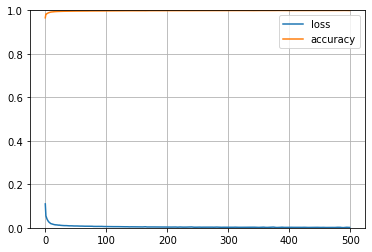

In [ ]:
print(AutoEncoder.evaluate(test_images,test_masks))
pd.DataFrame(hist.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
AutoEncoder.evaluate(test_images,test_masks)

In [ ]:
predictions = AutoEncoder.predict(test_images)

In [ ]:
mse = np.mean(np.power(test_images - predictions, 2), axis=1)
mse.shape

(264, 128, 1)

In [ ]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

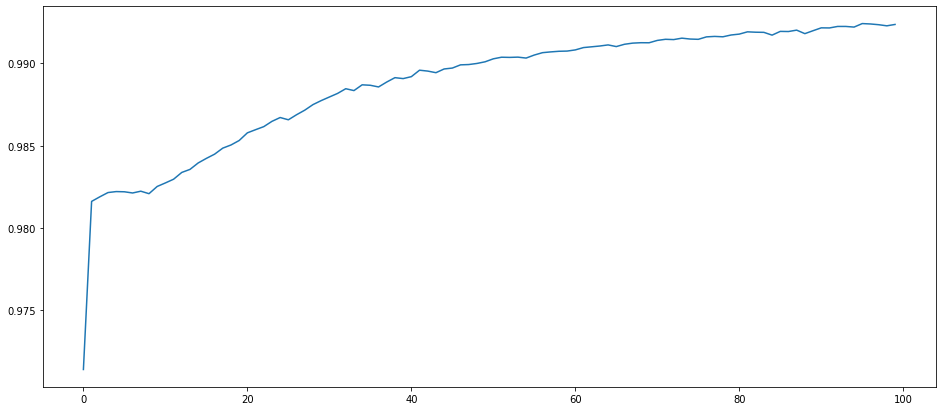

In [ ]:
plt.plot(hist.history['dice_coef'])
plt.show()

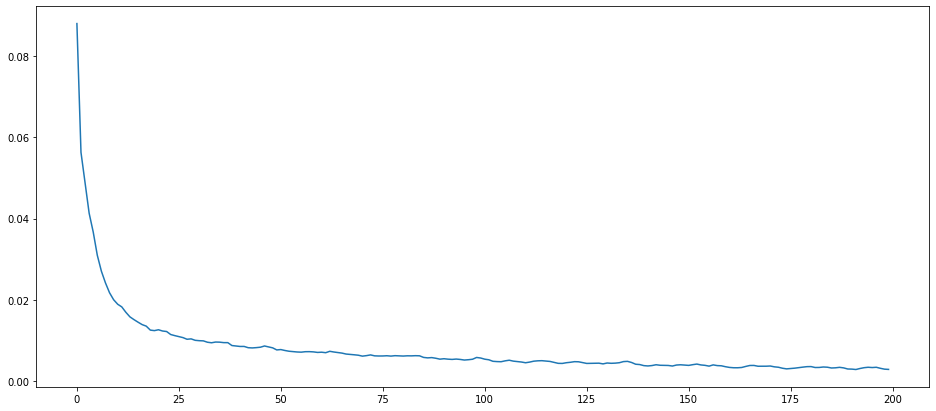

In [ ]:
plt.plot(hist.history['loss'])
plt.show()

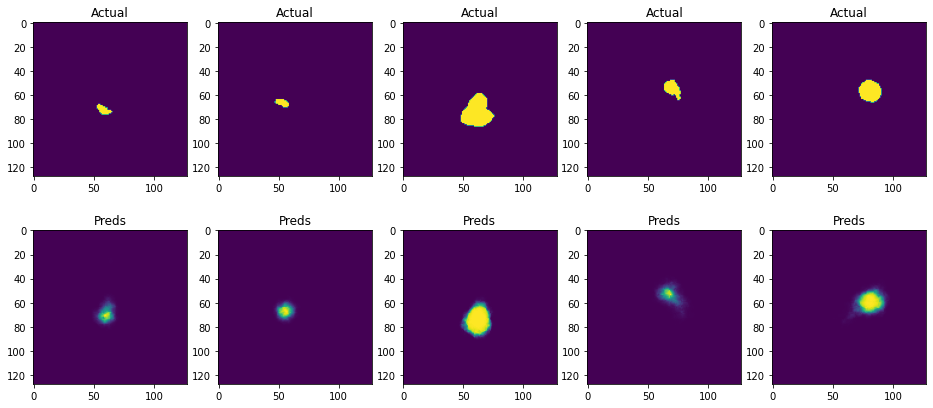

In [ ]:
preds=AutoEncoder.predict(train_images)
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((train_masks[i]).reshape(128,128))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow(np.array(preds[i]).reshape(128,128))
  plt.title('Preds')
plt.show()

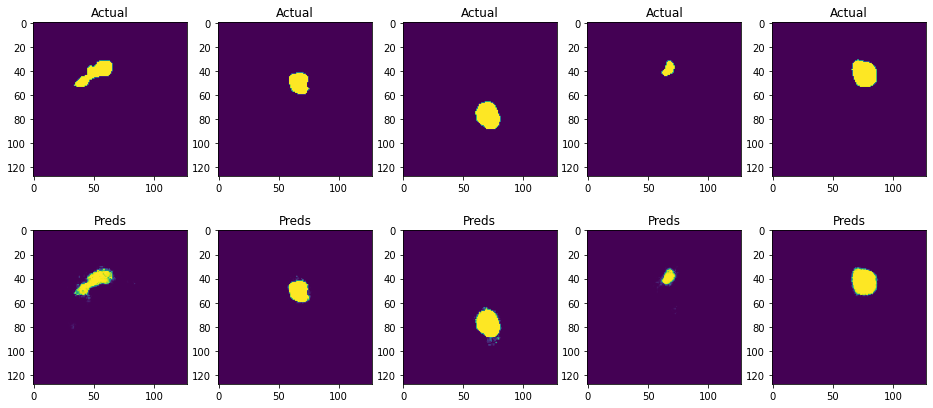

In [ ]:
preds=AutoEncoder.predict(train_images)
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((train_masks[i+20]).reshape(128,128))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow(np.array(preds[i+20]).reshape(128,128))
  plt.title('Preds')
plt.show()

## Exp 2

In [ ]:
Encoder=keras.models.Sequential([
      keras.layers.Input(shape=(128,128,1)),
      keras.layers.Conv2D(16,(3,3),padding='same' ),
      keras.layers.MaxPooling2D((2,2)),
      keras.layers.Conv2D(8,(3,3),padding='same' ),
      keras.layers.MaxPooling2D((2,2)),
      # keras.layers.Conv2D(4,(3,3),padding='same'),
      keras.layers.Flatten(),
      keras.layers.Dense(512,activation='relu'),
      keras.layers.Dense(256,activation='relu'),
      keras.layers.Dense(128,activation='relu'),
      keras.layers.Dense(64,activation='relu'),
      keras.layers.Dense(8)
])
Decoder=keras.models.Sequential([
  keras.layers.Input(shape=[8]),
  keras.layers.Dense(128,activation='selu'),
  keras.layers.Reshape((4,4,8)),
  keras.layers.Conv2DTranspose(32,(3,3)),
  keras.layers.Conv2DTranspose(16,(3,3)),
  keras.layers.UpSampling2D(),
  keras.layers.Conv2DTranspose(16,(3,3)),
  keras.layers.Conv2DTranspose(8,(3,3)),
  keras.layers.UpSampling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(16384,activation='sigmoid'),
  keras.layers.Reshape((128,128,1))
])

AutoEncoder=keras.models.Model([Encoder.input],[Decoder(Encoder.output)])
def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return ((2. * intersection ) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) ))

AutoEncoder.compile(optimizer=keras.optimizers.Adam (learning_rate=0.001),
                    loss=dice_coef,metrics=[keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.4)])
hist=AutoEncoder.fit(train_images,train_masks,epochs=100)


In [ ]:
print(AutoEncoder.evaluate(test_images,test_masks))
pd.DataFrame(hist.history).plot()
plt.grid()
plt.gca().set_ylim(0,0.05)
plt.show()

In [ ]:
preds=AutoEncoder.predict(train_images)
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((train_masks[i]).reshape(128,128))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow(np.array(preds[i]).reshape(128,128))
  plt.title('Preds')
plt.show()

## Convolutional Net

In [ ]:
import tensorflow
img_size = 128
num_channels = 1
latent_space_dim = 2

x = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="encoder_input")
encoder_conv_layer1 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)

encoder_conv_layer2 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_norm_layer1)
encoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)

encoder_conv_layer3 = tensorflow.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_norm_layer2)
encoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_conv_layer3)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_conv_layer3)

encoder_dense = tensorflow.keras.layers.Dense(units=16, name="encoder_mu")(encoder_flatten)
output = tensorflow.keras.layers.Dense(units=latent_space_dim,activation='sigmoid', name="encoder_log_variance")(encoder_dense)

encoder = tensorflow.keras.models.Model(x, output, name="encoder_model")

In [ ]:
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")
decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=np.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)

decoder_conv_tran_layer1 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3),activation='relu', padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)

decoder_conv_tran_layer2 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3),activation='relu', padding="same", strides=2, name="decoder_conv_tran_2")(decoder_norm_layer1)
decoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)

decoder_conv_tran_layer3 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3),activation='relu', padding="same", strides=2, name="decoder_conv_tran_3")(decoder_norm_layer2)
decoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)

decoder_conv_tran_layer4 = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), padding="same", strides=1,activation='sigmoid', name="decoder_conv_tran_4")(decoder_norm_layer3)
decoder = tensorflow.keras.models.Model(decoder_input, decoder_conv_tran_layer4, name="decoder_model")

In [ ]:
u=(Encoder(tf.random.uniform((5,128,128,1))))
decoder(u)

In [ ]:
vae_input = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="VAE_input")
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1-((2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.))

vae.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), loss=dice_coef)
h=vae.fit(train_images,train_masks, epochs=50)

9/9 [==============================] - 1s 36ms/step - loss: 0.6163
0.6162680983543396


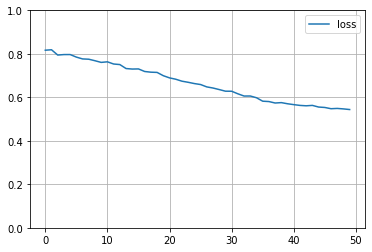

In [ ]:
print(vae.evaluate(test_images,test_masks))
pd.DataFrame(h.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

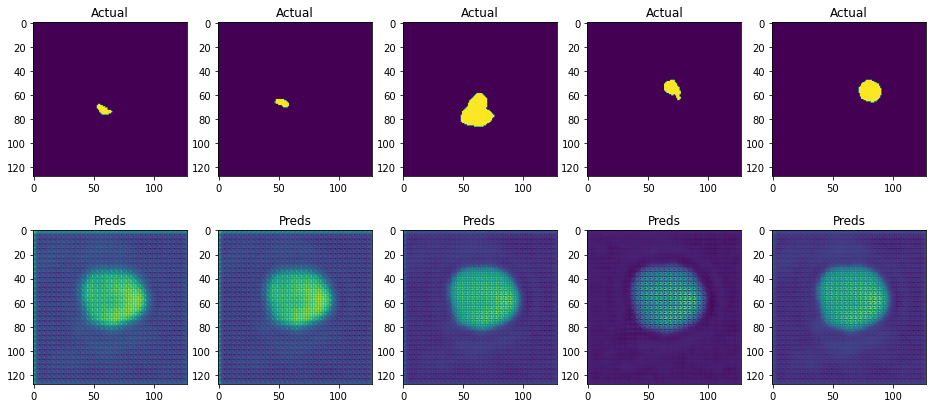

In [ ]:
preds=vae.predict(train_images)
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((train_masks[i]).reshape(128,128))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow(np.array(preds[i]).reshape(128,128))
  plt.title('Preds')
plt.show()

## Exp 3

In [ ]:
vae_input = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="VAE_input")
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
vae.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.001), loss='binary_crossentropy',metrics=[dice_coef])
h=vae.fit(train_images,train_masks, epochs=20)

In [ ]:
from tensorflow import keras
from keras import layers

def double_conv_block(x, n_filters):
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x=layers.BatchNormalization()(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = layers.concatenate([x, conv_features])
   x = layers.Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x
inputs = layers.Input(shape=(128,128,1))
f1, p1 = downsample_block(inputs, 8)
f2, p2 = downsample_block(p1, 16)
f3, p3 = downsample_block(p2, 32)
f4, p4 = downsample_block(p3, 64)

# 5 - bottleneck
bottleneck = double_conv_block(p4, 24)


u6 = upsample_block(bottleneck, f4, 64)
u7 = upsample_block(u6, f3, 32)
u8 = upsample_block(u7, f2, 16)
u9 = upsample_block(u8, f1, 8)

outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)
unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

from keras import backend as K
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
  return 1-dice_coef(y_true, y_pred)

unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=[dice_coef,keras.metrics.Recall()])
model_history = unet_model.fit(train_images,train_masks,epochs=1000)

Epoch 1/1000
88/88 [==============================] - 21s 56ms/step - loss: 0.6390 - dice_coef: 0.0357 - recall: 0.3693
Epoch 2/1000
88/88 [==============================] - 4s 48ms/step - loss: 0.4313 - dice_coef: 0.0353 - recall: 0.0027
Epoch 3/1000
88/88 [==============================] - 4s 48ms/step - loss: 0.2818 - dice_coef: 0.0353 - recall: 2.8118e-04
Epoch 4/1000
88/88 [==============================] - 4s 48ms/step - loss: 0.1861 - dice_coef: 0.0355 - recall: 3.2783e-05
Epoch 5/1000
88/88 [==============================] - 4s 49ms/step - loss: 0.1351 - dice_coef: 0.0371 - recall: 0.0000e+00
Epoch 6/1000
88/88 [==============================] - 4s 49ms/step - loss: 0.1055 - dice_coef: 0.0545 - recall: 0.0017
Epoch 7/1000
88/88 [==============================] - 4s 49ms/step - loss: 0.0848 - dice_coef: 0.0996 - recall: 0.0642
Epoch 8/1000
88/88 [==============================] - 4s 49ms/step - loss: 0.0707 - dice_coef: 0.1535 - recall: 0.1702
Epoch 9/1000
88/88 [===============

9/9 [==============================] - 1s 41ms/step - loss: 0.0207 - dice_coef: 0.8322 - recall: 0.8693
[0.020689407363533974, 0.832176923751831, 0.8693216443061829]


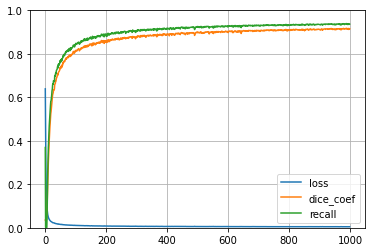

In [ ]:
print(unet_model.evaluate(test_images,test_masks))
pd.DataFrame(model_history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

9/9 [==============================] - 0s 12ms/step - loss: 0.0207 - dice_coef: 0.8322 - recall: 0.8693
[0.020689407363533974, 0.832176923751831, 0.8693216443061829]


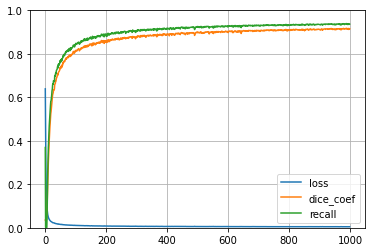

In [ ]:
print(unet_model.evaluate(test_images,test_masks))
pd.DataFrame(model_history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
unet_model.save('/content/drive/MyDrive/datasets/BRAIN_TUMOR_DATA_STORE/autoencoder_brain_unet.h5')

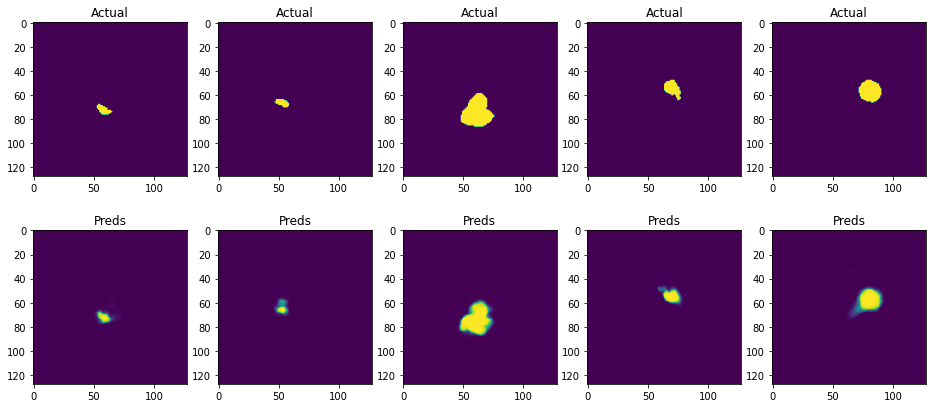

In [ ]:
preds=unet_model.predict(train_images)
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((train_masks[i]).reshape(128,128))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow(np.array(preds[i]).reshape(128,128))
  plt.title('Preds')
plt.show()